In [ ]:
# 출처 : https://wikidocs.net/44249

**목적** : (0~1 사이의)scoreing 기반 예측(0/1 값 기준) 


**내용**
1. [x] data load(train/test 각각)
2. [x] 데이터 전처리
  - [x] A.데이터 정제(1차)
  - [x] B.토큰화 
  - [x] C.정수 인코딩
  - [x] D.데이터 정제(2차)
  - [x] E.패딩
3. [x] 모델링(LSTM)
4. [x] 예측

In [35]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


### 1.data load/check

In [2]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1b5c409f0c8>)

In [11]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [32]:
train_data['document'] = train_data['document'].astype(str)

In [102]:
train_data.tail(2)

,id,document,label
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143681 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        143681 non-null  int64 
 1   document  143681 non-null  object
 2   label     143681 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [103]:
train_data['label'].value_counts()

0    72215
1    71466
Name: label, dtype: int64

In [26]:
test_data.tail(2)

,id,document,label
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0


In [30]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48995 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48995 non-null  int64 
 1   document  48995 non-null  object
 2   label     48995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


### 2-A.데이터 정제(1차)

In [69]:
#변경 전
print('최초 샘플의 개수 :',len(train_data))

# 중복 제거
train_data.drop_duplicates(subset = ['document'], inplace=True) 

# 정규 표현식 수행
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

# 공백은 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
train_data = train_data.dropna(how='any')

#변경 후
print('전처리 후 샘플의 개수 :',len(train_data))

최초 샘플의 개수 : 143681
전처리 후 샘플의 개수 : 143681


In [68]:
#변경 전
print('최초 샘플의 개수 :',len(test_data))

# 중복 제거
test_data.drop_duplicates(subset = ['document'], inplace=True) 

# 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

# 공백은 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any')

#변경 후
print('전처리 후 샘플의 개수 :',len(test_data))

최초 샘플의 개수 : 48417
전처리 후 샘플의 개수 : 48417


### B.토큰화

In [37]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [72]:
%%time 

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

Wall time: 5min 38s


In [73]:
%%time 

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

Wall time: 1min 57s


### C.정수 인코딩

In [74]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [75]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0   # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.631742548912044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8757278609673573


In [76]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [77]:
# TF input 크기와 직결됨
vocab_size = total_cnt - rare_cnt + 2

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [78]:
print(X_train[:3])

[[51, 456, 17, 263, 660], [948, 457, 42, 603, 2, 215, 1449, 25, 962, 677, 20], [386, 2443, 1, 2313, 5667, 3, 222, 10]]


In [79]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### D.데이터 정제(2차)

In [80]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

143651
143651


### E.패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.11225818128659


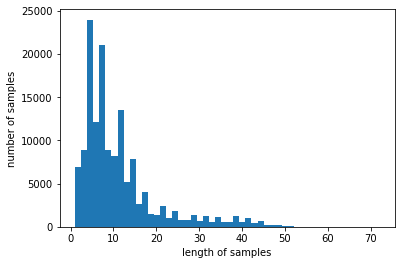

In [81]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [82]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [107]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [84]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### LSTM

In [85]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [117]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='relu'))

In [87]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [108]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1941400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,058,777
Trainable params: 2,058,777
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Train on 114920 samples, validate on 28731 samples
Epoch 1/15
114900/114920 [============================>.] - ETA: 0s - loss: 0.2163 - acc: 0.9138
Epoch 00001: val_acc did not improve from 0.86106
114920/114920 [==============================] - 186s 2ms/sample - loss: 0.2164 - acc: 0.9137 - val_loss: 0.3577 - val_acc: 0.8551
Epoch 2/15
114900/114920 [============================>.] - ETA: 0s - loss: 0.1597 - acc: 0.9396- ETA: 0s - loss: 0.1598 - ac
Epoch 00002: val_acc did not improve from 0.86106
114920/114920 [==============================] - 201s 2ms/sample - loss: 0.1597 - acc: 0.9396 - val_loss: 0.4168 - val_acc: 0.8419
Epoch 3/15
114900/114920 [============================>.] - ETA: 0s - loss: 0.1166 - acc: 0.9569
Epoch 00003: val_acc did not improve from 0.86106
114920/114920 [==============================] - 205s 2ms/sample - loss: 0.1166 - acc: 0.9569 - val_loss: 0.5166 - val_acc: 0.8335
Epoch 4/15
114900/114920 [============================>.] - ETA: 0s - loss: 0.0861 - a

In [121]:
# evaluation
# results = model.evaluate(test_data, verbose =2)
# for name, value in zip(model.metrics_names, results):
#     print("%s: %.3f" % (name, value))

In [110]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

48417/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


 테스트 정확도: 0.8559


In [122]:
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

48417/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

테스트 정확도: 0.8559


In [ ]:
### evaluation

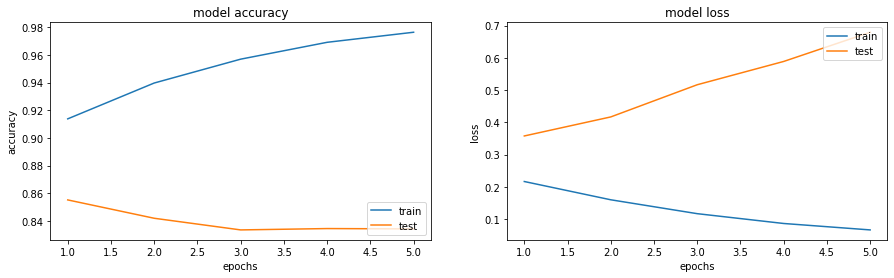

In [129]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
### 결과 예측

In [111]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [112]:
print('Text : {}'.format('저렴하게 잘 샀어요'))
sentiment_predict('저렴하게 잘 샀어요')

Text : 저렴하게 잘 샀어요
80.10% 확률로 부정 리뷰입니다.



In [113]:
text = '저렴하게 유용하게 잘 사용했어요'
print('Text : {}'.format(text))
sentiment_predict(text)

Text : 저렴하게 유용하게 잘 사용했어요
87.62% 확률로 부정 리뷰입니다.



In [114]:
text = '폴바셋 라떼와 아이스크림은 사랑입니다♡♡♡ 티몬 최고!! 매일두 앱은 이번에 처음 알게되서 깔았는데 혜택이 많네요! 감사합니다.'
print('Text : {}'.format(text))
sentiment_predict(text)

Text : 폴바셋 라떼와 아이스크림은 사랑입니다♡♡♡ 티몬 최고!! 매일두 앱은 이번에 처음 알게되서 깔았는데 혜택이 많네요! 감사합니다.
98.03% 확률로 긍정 리뷰입니다.



In [115]:
text = '폴바셋첨가봤는데 최고네요 서비스가 국내최고급인듯 호텔고급카페에온기분'
print('Text : {}'.format(text))
sentiment_predict(text)

Text : 폴바셋첨가봤는데 최고네요 서비스가 국내최고급인듯 호텔고급카페에온기분
98.56% 확률로 긍정 리뷰입니다.

